# nmt

参考nmt模型搭建一个seq2seq的翻译系统，和之前seq2seq的区别在于加入attention，并且采用了更快的训练方法。

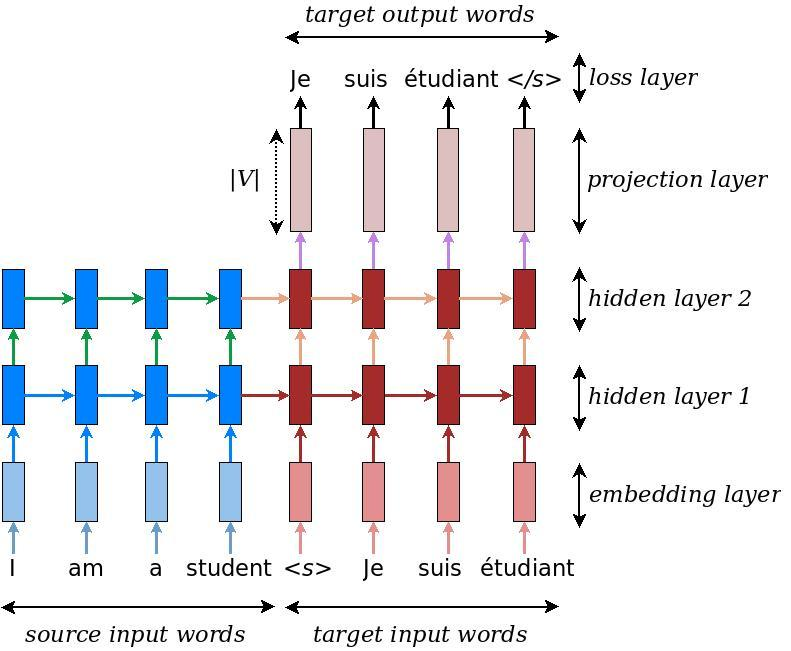

## 数据处理

At the bottom layer, the encoder and decoder RNNs receive as input the following: first, the source sentence, then a boundary marker "<s\>" which indicates the transition from the encoding to the decoding mode, and the target sentence. For training, we will feed the system with the following tensors, which are in time-major format and contain word indices:

- encoder_inputs [max_encoder_time, batch_size]: source input words.
- decoder_inputs [max_decoder_time, batch_size]: target input words.
- decoder_outputs [max_decoder_time, batch_size]: target output words, these are decoder_inputs shifted to the left by one time step with an end-of-sentence tag appended on the right.

Here for efficiency, we train with multiple sentences (batch_size) at once. Testing is slightly different, so we will discuss it later.

我们按照[max_encoder_time, batch_size]的格式将每一个batch的数据进行处理。

In [1]:
# ========读取原始数据========
with open('cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.split('\n')
data = data[:1500]
print(data[-5:])


# 分割英文数据和中文数据
en_data = [line.split('\t')[0] for line in data]
ch_data = [line.split('\t')[1] for line in data]
print('英文数据:\n', en_data[:10])
print('\n中文数据:\n', ch_data[:10])

['Turn off the gas.\t把煤气关了！', 'Turn to the left.\t向左转。', 'We accept checks.\t我們接受支票。', 'We depend on you.\t我们可全指望你了。', 'We depend on you.\t我们可全靠你了。']
英文数据:
 ['Hi.', 'Hi.', 'Run.', 'Wait!', 'Hello!', 'I try.', 'I won!', 'Oh no!', 'Cheers!', 'He ran.']

中文数据:
 ['嗨。', '你好。', '你用跑的。', '等等！', '你好。', '让我来。', '我赢了。', '不会吧。', '乾杯!', '他跑了。']


In [2]:
# 特殊字符
SOURCE_CODES = ['<PAD>', '<UNK>']
TARGET_CODES = ['<PAD>', '<EOS>', '<UNK>', '<GO>']  # 在target中，需要增加<GO>与<EOS>特殊字符

# 分别生成中英文字典
en_vocab = set(''.join(en_data))
id2en = SOURCE_CODES + list(en_vocab)
en2id = {c:i for i,c in enumerate(id2en)}

# 分别生成中英文字典
ch_vocab = set(''.join(ch_data))
id2ch = TARGET_CODES + list(ch_vocab)
ch2id = {c:i for i,c in enumerate(id2ch)}

print('\n英文字典:\n', en2id)
print('\n中文字典共计\n:', ch2id)


英文字典:
 {'<PAD>': 0, '<UNK>': 1, 'c': 2, ':': 3, 'j': 4, 'b': 5, 'Q': 6, 'R': 7, 'd': 8, 'E': 9, 'u': 10, '9': 11, '.': 12, 'U': 13, '8': 14, 'o': 15, 'p': 16, '?': 17, ' ': 18, 'i': 19, 'P': 20, '-': 21, 'n': 22, '!': 23, 'T': 24, 'J': 25, 'G': 26, 'Y': 27, '"': 28, 'e': 29, 'C': 30, 'g': 31, 'S': 32, 'x': 33, 'z': 34, ',': 35, 'H': 36, 'L': 37, 'w': 38, 'q': 39, 'N': 40, 'l': 41, 'I': 42, 'W': 43, 's': 44, "'": 45, 'm': 46, 'v': 47, '1': 48, 'V': 49, 'a': 50, 'y': 51, 'M': 52, 't': 53, 'K': 54, 'B': 55, 'k': 56, 'F': 57, 'h': 58, 'D': 59, '3': 60, 'O': 61, '7': 62, 'f': 63, 'r': 64, 'A': 65, '0': 66}

中文字典共计
: {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3, '鉛': 4, '電': 5, '欣': 6, '瓦': 7, '敬': 8, '点': 9, '证': 10, '止': 11, '睡': 12, '懂': 13, '釣': 14, '擊': 15, '響': 16, '旗': 17, '覺': 18, '份': 19, '才': 20, '慢': 21, '棄': 22, '秘': 23, '記': 24, '飞': 25, '職': 26, '之': 27, '键': 28, '年': 29, '帽': 30, '麻': 31, '意': 32, '餐': 33, '無': 34, '吐': 35, '甜': 36, '邊': 37, '罪': 38, '危': 39, '挺': 40, '滿': 

In [3]:
import numpy as np
# 利用字典，映射数据
en_num_data = [[en2id[en] for en in line] for line in en_data]
ch_num_data = [[ch2id['<GO>']] + [ch2id[ch] for ch in line] for line in ch_data]
de_num_data = [[ch2id[ch] for ch in line] + [ch2id['<EOS>']] for line in ch_data]

print('char:', en_data[1])
print('index:', en_num_data[1])


# 设计数据生成器
def batch_data(en_num_data, ch_num_data, de_num_data, batch_size):
    batch_num = len(en_num_data) // batch_size
    for i in range(batch_num):
        begin = i * batch_size
        end = begin + batch_size
        encoder_inputs = en_num_data[begin:end]
        decoder_inputs = ch_num_data[begin:end]
        decoder_targets = de_num_data[begin:end]
        encoder_lengths = [len(line) for line in encoder_inputs]        
        decoder_lengths = [len(line) for line in decoder_inputs]
        encoder_max_length = max(encoder_lengths)
        decoder_max_length = max(decoder_lengths)
        encoder_inputs = np.array([data + [en2id['<PAD>']] * (encoder_max_length - len(data)) for data in encoder_inputs]).T
        decoder_inputs = np.array([data + [ch2id['<PAD>']] * (decoder_max_length - len(data)) for data in decoder_inputs]).T
        decoder_targets = np.array([data + [ch2id['<PAD>']] * (decoder_max_length - len(data)) for data in decoder_targets]).T
        mask = decoder_targets > 0
        target_weights = mask.astype(np.float32)
        yield encoder_inputs, decoder_inputs, decoder_targets, target_weights, encoder_lengths, decoder_lengths
              


char: Hi.
index: [36, 19, 12]


In [4]:
import tensorflow as tf

keepprb = 0.9

EN_VOCAB_SIZE = len(en2id)
CH_VOCAB_SIZE = len(ch2id)

HIDDEN_LAYERS = 2
HIDDEN_SIZE = 256

learning_rate = 0.001

BATCH_SIZE = 32
BATCH_NUMS = len(ch_num_data) // BATCH_SIZE
MAX_GRAD_NORM = 1

EPOCHS = 50


## placeholder

In [5]:
encoder_inputs = tf.placeholder(tf.int32, [None, BATCH_SIZE])
decoder_inputs = tf.placeholder(tf.int32, [None, BATCH_SIZE])
decoder_targets = tf.placeholder(tf.int32, [None, BATCH_SIZE])
target_weights = tf.placeholder(tf.float32, [None, BATCH_SIZE])
source_sequence_length = tf.placeholder(tf.int32, [BATCH_SIZE,])
decoder_lengths = tf.placeholder(tf.int32, [BATCH_SIZE,])

keepprb = tf.placeholder(tf.float32)

## Embedding词嵌入层

In [6]:
# encoder
with tf.name_scope('embedding_encoder'):
	encoder_embedding = tf.get_variable('embedding_encoder', [EN_VOCAB_SIZE, HIDDEN_SIZE])
	encoder_emb = tf.nn.embedding_lookup(encoder_embedding, encoder_inputs)
	encoder_emb = tf.nn.dropout(encoder_emb, keepprb)

    
# decoder
with tf.name_scope('embedding_decoder'):
	decoder_embedding = tf.get_variable('embedding_decoder', [CH_VOCAB_SIZE, HIDDEN_SIZE])
	decoder_emb = tf.nn.embedding_lookup(decoder_embedding, decoder_inputs)
	decoder_emb = tf.nn.dropout(decoder_emb, keepprb)

## Encoder
Once retrieved, the word embeddings are then fed as input into the main network, which consists of two multi-layer RNNs – an encoder for the source language and a decoder for the target language. These two RNNs, in principle, can share the same weights; however, in practice, we often use two different RNN parameters (such models do a better job when fitting large training datasets). The encoder RNN uses zero vectors as its starting states and is built as follows:
```py
# Build RNN cell
encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

# Run Dynamic RNN
#   encoder_outputs: [max_time, batch_size, num_units]
#   encoder_state: [batch_size, num_units]
encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_emb_inp,
    sequence_length=source_sequence_length, time_major=True)
```
Note that sentences have different lengths to avoid wasting computation, we tell dynamic_rnn the exact source sentence lengths through source_sequence_length. Since our input is time major, we set time_major=True. Here, we build only a single layer LSTM, encoder_cell. We will describe how to build multi-layer LSTMs, add dropout, and use attention in a later section.

In [7]:
def create_rnn_cell(layer_num=HIDDEN_LAYERS):
    def single_rnn_cell():
        single_cell = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE)
        #添加dropout
        cell = tf.contrib.rnn.DropoutWrapper(single_cell, output_keep_prob=keepprb)
        return cell
    cell = tf.contrib.rnn.MultiRNNCell([single_rnn_cell() for _ in range(layer_num)])
    return cell


# encoder
with tf.variable_scope('encoder'):
	encoder_cell = create_rnn_cell()
	initial_state = encoder_cell.zero_state(BATCH_SIZE, tf.float32)
	encoder_outputs, final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_emb, sequence_length=source_sequence_length, 
                                       time_major=True, initial_state=initial_state)

In [8]:
memory = tf.transpose(encoder_outputs, [1, 0, 2])
# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(HIDDEN_SIZE, memory, memory_sequence_length=source_sequence_length)


## Decoder

In [9]:
from tensorflow.python.layers.core import Dense

# decoder cell
with tf.variable_scope('decoder_cell'):
    decoder_cell = create_rnn_cell()
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(decoder_cell, attention_mechanism, attention_layer_size=HIDDEN_SIZE)
    # Helper 
    projection_layer = Dense(CH_VOCAB_SIZE, use_bias=False)
    helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb, decoder_lengths, time_major=True)
    init_state = decoder_cell.zero_state(BATCH_SIZE, tf.float32).clone(cell_state=final_state)
    decoder_cell = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, init_state, output_layer=projection_layer)
    outputs, final_state, final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(decoder_cell, output_time_major=True, swap_memory=True,)
    logits = outputs.rnn_output
    print(logits)

Tensor("decoder_cell/decoder/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 32, 1131), dtype=float32)


## Optimizer

In [10]:
with tf.variable_scope('optimizer'):
    # ======计算损失=======
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=decoder_targets, logits=logits)
    cost = (tf.reduce_sum((loss * target_weights) / BATCH_SIZE))

    # =============优化算法==============
    # =============学习率衰减==============
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, BATCH_NUMS, 0.99, staircase=True)

                # =======通过clip_by_global_norm()控制梯度大小======
    trainable_variables = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, trainable_variables), MAX_GRAD_NORM)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(grads, trainable_variables))

		# ==============预测输出=============
predict = tf.argmax(logits[:, 0, :], 1)

## train model

In [11]:
# 保存模型
saver = tf.train.Saver()
with tf.Session() as sess:
	writer = tf.summary.FileWriter('logs/tensorboard', tf.get_default_graph())
	sess.run(tf.global_variables_initializer())
	for k in range(EPOCHS):
		total_loss = 0.
		data_generator = batch_data(en_num_data, ch_num_data, de_num_data, BATCH_SIZE)
		for i in range(BATCH_NUMS):
			en_input, de_input, de_tg, tg_weight, en_len, de_len = next(data_generator)
			feed = {encoder_inputs: en_input, decoder_inputs: de_input, decoder_targets: de_tg, target_weights: tg_weight, source_sequence_length: en_len, decoder_lengths: de_len, keepprb: 0.8}
			costs, _ = sess.run([cost, opt], feed_dict=feed)
			total_loss += costs
			if (i+1) % 10 == 0:
				print('epochs:', k + 1, 'iter:', i + 1, 'cost:', total_loss / i + 1)
				#print('predict:', sess.run(predict[0], feed_dict=feed))
				print('text:', ''.join([id2ch[i] for i in sess.run(predict, feed_dict=feed)]))
				print('label:', ''.join([id2ch[i] for i in de_tg[:, 0]]))
                
	saver.save(sess, './checkpoints/lstm.ckpt')

writer.close()

epochs: 1 iter: 10 cost: 41.591375986735024
text: 。。。。。。。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 1 iter: 20 cost: 37.43494806791607
text: 我我我。。。。。。。
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 1 iter: 30 cost: 36.66013750536688
text: 我我我我。<EOS><EOS><EOS><EOS><EOS>
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 1 iter: 40 cost: 36.587548329279976
text: 我我是了。<EOS><EOS><EOS><EOS><EOS><EOS>
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 2 iter: 10 cost: 28.85248523288303
text: 我我我。<EOS><EOS><EOS><EOS><EOS><EOS>
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 2 iter: 20 cost: 29.212752593191045
text: 我我。。。。<EOS><EOS><EOS><EOS>
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 2 iter: 30 cost: 30.242603696625807
text: 我你是。。。<EOS><EOS><EOS><EOS>
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 2 iter: 40 cost: 31.155283610026043
text: 我是是。。。。<EOS><EOS><EOS><EOS>
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 3 iter: 10 cost: 27.01336118910048
text: 我是。。。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epoch

epochs: 21 iter: 10 cost: 9.284618748558891
text: 我必你。。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 21 iter: 20 cost: 10.28474007154766
text: 找保許姆椅椅。<EOS>！。
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 21 iter: 30 cost: 10.692863020403632
text: 你还识我吗？<EOS>？？？
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 21 iter: 40 cost: 11.306739697089562
text: 離開草坪!<EOS>。嘴！。儿
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 22 iter: 10 cost: 8.948815451727974
text: 我生你。。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 22 iter: 20 cost: 9.583569627059134
text: 让一汤姆安助。<EOS>！！
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 22 iter: 30 cost: 9.897826951125573
text: 你认识我吗？<EOS>？吗吗
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 22 iter: 40 cost: 10.51531432225154
text: 離開草坪!<EOS>！梦梦梦！
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 23 iter: 10 cost: 8.166982968648274
text: 我信你。。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 23 iter: 20 cost: 8.826723525398656
text: 让一汤姆打。。<EOS>我。
label: 确保汤姆安全。<EOS

epochs: 41 iter: 20 cost: 2.133515439535442
text: 确保汤姆安全。<EOS>。。
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 41 iter: 30 cost: 2.2046473026275635
text: 你认识他吗?<EOS>吗？？
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 41 iter: 40 cost: 2.311543018389971
text: 離開草坪!<EOS>吗!!。。
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 42 iter: 10 cost: 2.032745235496097
text: 我聽你的。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 42 iter: 20 cost: 2.1478455098051774
text: 确保汤姆安全。<EOS>。。
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 42 iter: 30 cost: 2.2462907351296524
text: 你认识他吗?<EOS>吗？？
label: 你认识他吗?<EOS><PAD><PAD><PAD>
epochs: 42 iter: 40 cost: 2.328068970105587
text: 離開草坪!<EOS>吗吗。。！
label: 離開草坪!<EOS><PAD><PAD><PAD><PAD><PAD>
epochs: 43 iter: 10 cost: 2.0300880670547485
text: 我聽你的。<EOS>。。。。
label: 我聽你的。<EOS><PAD><PAD><PAD><PAD>
epochs: 43 iter: 20 cost: 2.1823433229797766
text: 确保汤姆安全。<EOS>。。
label: 确保汤姆安全。<EOS><PAD><PAD>
epochs: 43 iter: 30 cost: 2.1731626699710715
text: 你认识他吗?<EOS>???
label: 你认识他吗?<EOS><PAD